# Multiple Linear Regression

The goal is to 
 - perform a Multiple Linear Regression to expand my professional portfolio
 - and use it as a stepping stone from the Simple Linear Regression to the General Linearized Models.

In [1]:
# import section ------------------------------------------------------------------------------------------------------------- #

# relational database and mathematics related libraries ---------------------------------------------------------------------- #
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# specific functions and models ---------------------------------------------------------------------------------------------- #
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Testing Model assumptions -------------------------------------------------------------------------------------------------- #
# Tests for heteroscedasticity ----------------------------------------------------------------------------------------------- #
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt
# Tests for normality -------------------------------------------------------------------------------------------------------- #
from statsmodels.stats.diagnostic import normal_ad, kstest_normal
from statsmodels.stats.stattools import jarque_bera, omni_normtest
# Tests for constant error variance ------------------------------------------------------------------------------------------ #
from statsmodels.stats.diagnostic import acorr_breusch_godfrey


# libraries for visualization ------------------------------------------------------------------------------------------------ #
import seaborn as sns
import matplotlib.pyplot as plt

# load the data and save it into a dataframe --------------------------------------------------------------------------------- #
all_data_df = pd.read_csv("Fish.csv")

# cast Data Types as needed for model ---------------------------------------------------------------------------------------- #
all_data_df["Species"] = all_data_df["Species"].replace(to_replace={"Bream":0, "Parkki":1, "Perch":2, "Pike":3, "Roach":4, "Smelt":5, "Whitefish":6})

# intial print to get an overview over the data and it's usability ----------------------------------------------------------- #
#print(all_data_df.head())
print(all_data_df.info())
#print(all_data_df.Species.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    int64  
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 8.8 KB
None


<Figure size 640x480 with 0 Axes>

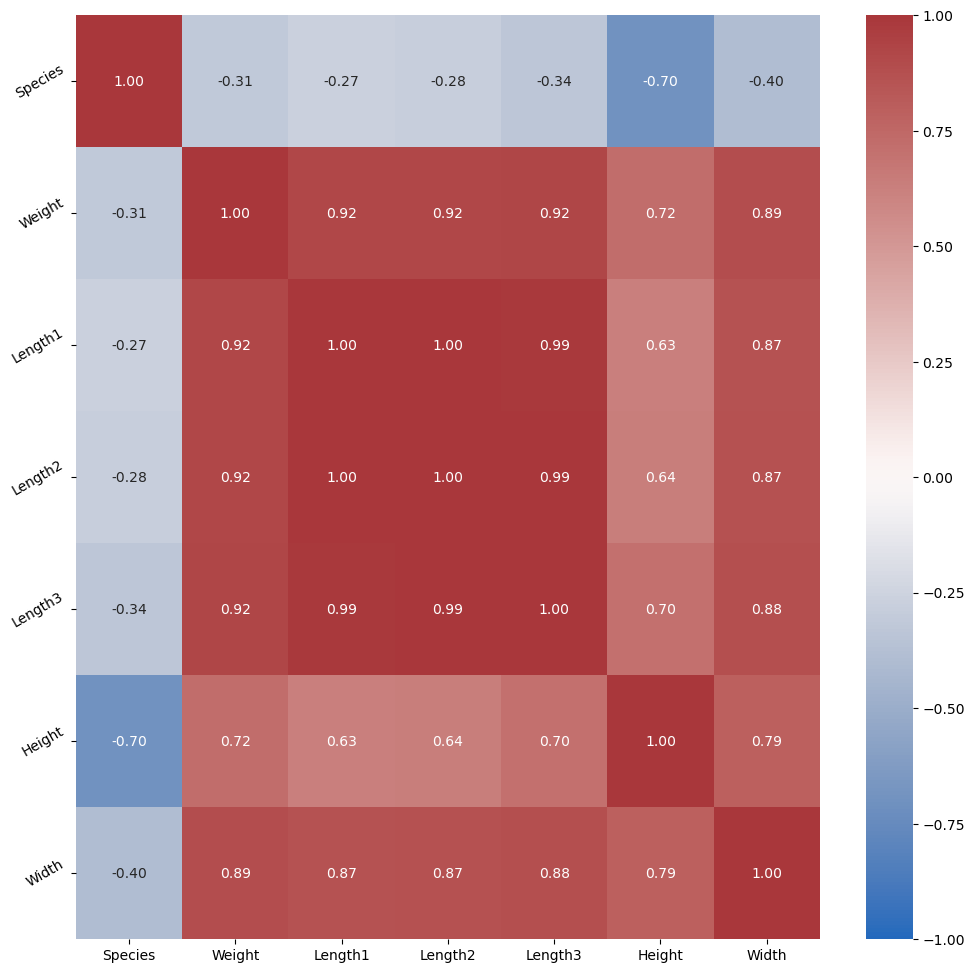

In [2]:
plt.clf()
# correlation matrix --------------------------------------------------------------------------------------------------------- #
corr = all_data_df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, cmap="vlag", annot=True, fmt=".2f")
plt.yticks(rotation=30)
plt.show()

<Figure size 640x480 with 0 Axes>

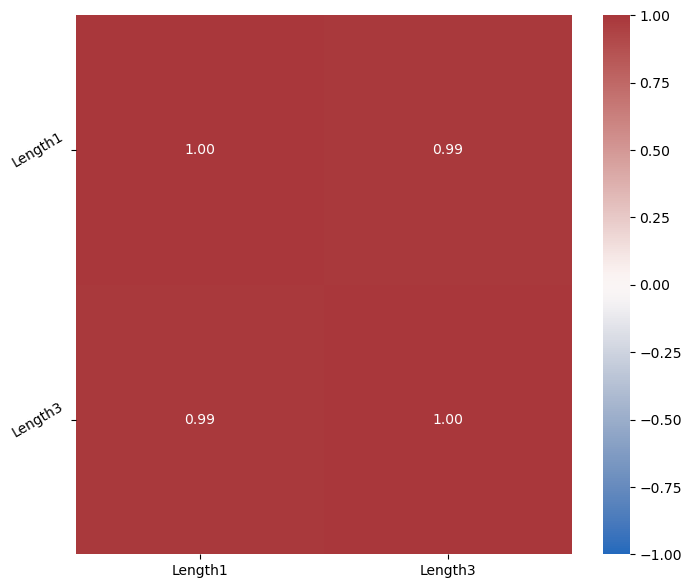

In [3]:
# predefined significance level predefined for all statistical tests --------------------------------------------------------- #
alpha = 0.05

# removing explaining variables, which are highly correlated with other explaining variables --------------------------------- #
# or which do not add any or only very little explainatory value ------------------------------------------------------------- #
predicted_variable = ["Length2"]

predicting_variables = ["Length1", "Length3"]

columns_to_drop = list(all_data_df.columns.values)

for var in predicting_variables:
    columns_to_drop.remove(var)

all_data_Y_dropped = all_data_df.drop(columns=predicted_variable)

model_df = all_data_df.drop(columns=columns_to_drop)

# correlation matrix --------------------------------------------------------------------------------------------------------- #
model_corr = model_df.corr()

plt.clf()
plt.figure(figsize=(8,7))
sns.heatmap(model_corr, vmin=-1, vmax=1, xticklabels=model_corr.columns, yticklabels=model_corr.columns, cmap="vlag", annot=True, fmt=".2f")
plt.yticks(rotation=30)
plt.show()

<Figure size 640x480 with 0 Axes>

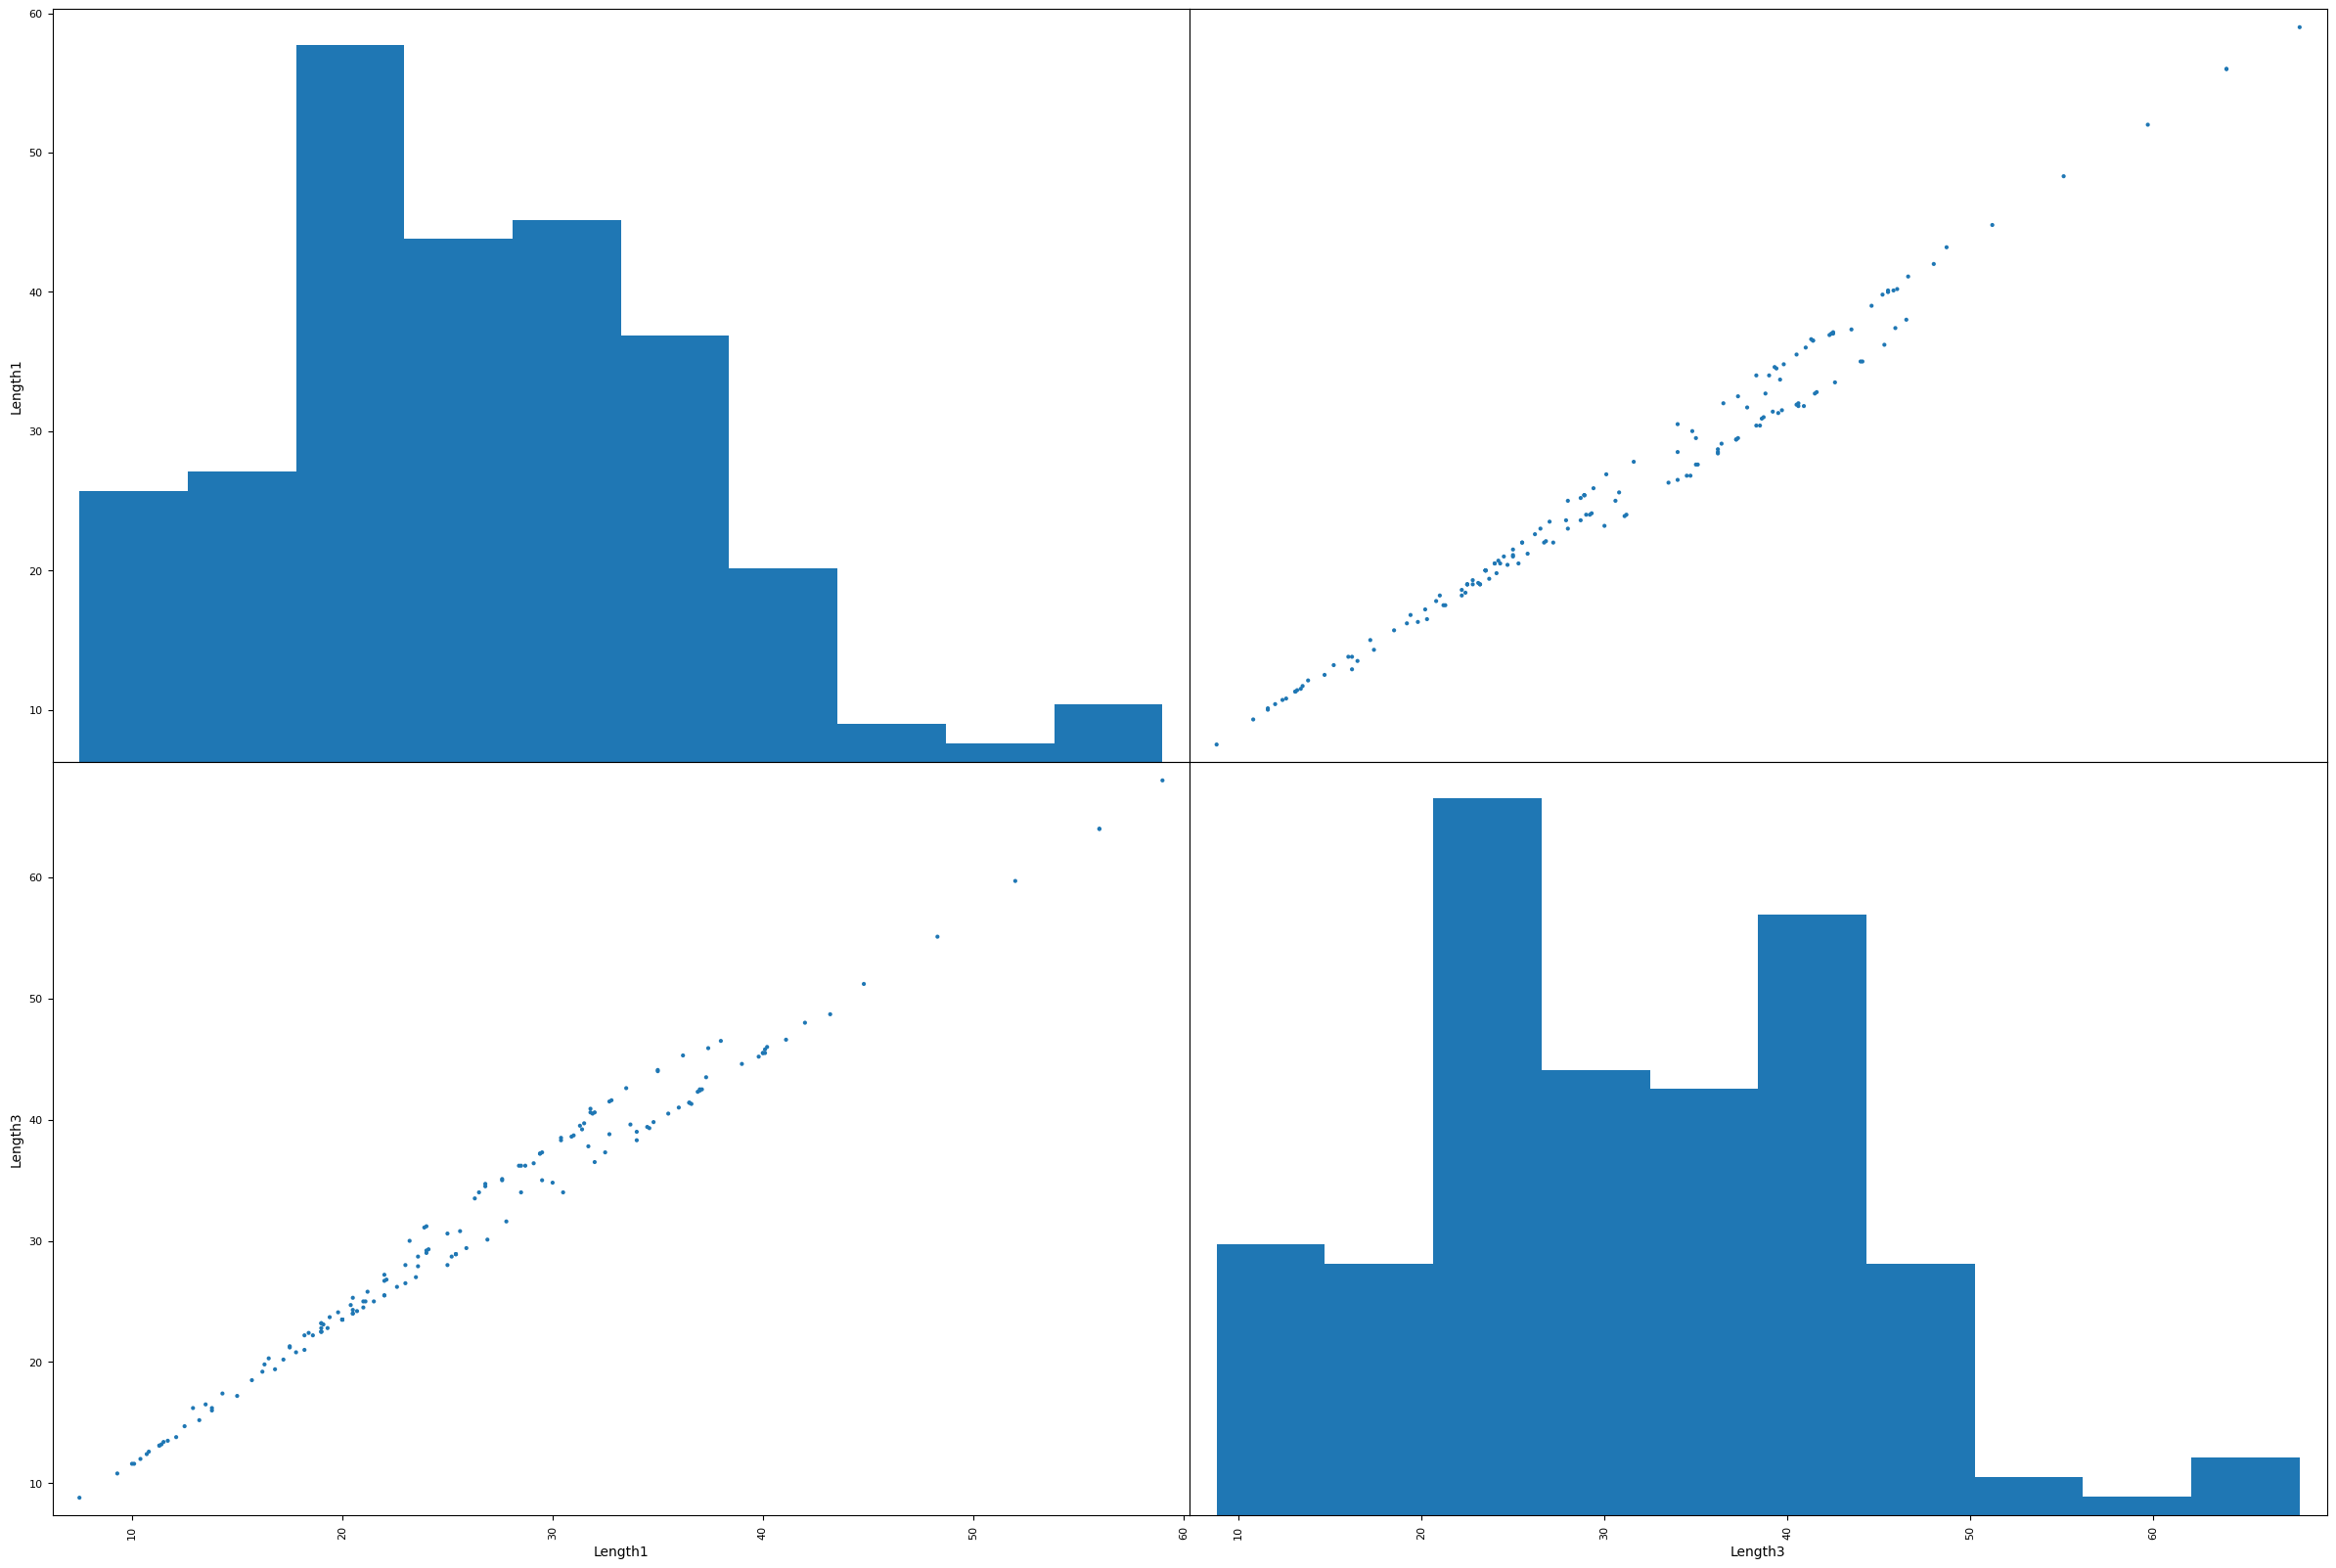

In [4]:
plt.clf()
# define the plot
pd.plotting.scatter_matrix(model_df, alpha = 1, figsize = (30, 20))

# show the plot
plt.show()

In [5]:
# Variance Inflation Factor, before and after dropping independent variables ------------------------------------------------- #

# dataframes of explaining variables (x), having removed the explained variable (y) ------------------------------------------ #
X_1 = all_data_Y_dropped

X_2 = model_df[predicting_variables]

Y = all_data_df[predicted_variable]
  
# VIF dataframe -------------------------------------------------------------------------------------------------------------- #
vif_data_1 = pd.DataFrame()
vif_data_1["feature"] = X_1.columns

vif_data_2 = pd.DataFrame()
vif_data_2["feature"] = X_2.columns
  
# calculating VIF for each feature ------------------------------------------------------------------------------------------- #
vif_data_1["VIF"] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

vif_data_2["VIF"] = [variance_inflation_factor(X_2.values, i) for i in range(len(X_2.columns))]

print("VIF=1: vars not correlated, 1<VIF<=5: vars moderatly correlated, 5<VIF<=10: vars highly correlated, VIF>10: abandon all hope")
print("")
print("Before dropping explaining variables:")
print(vif_data_1)
print("")
print("After dropping explaining variables:")
print(vif_data_2)

VIF=1: vars not correlated, 1<VIF<=5: vars moderatly correlated, 5<VIF<=10: vars highly correlated, VIF>10: abandon all hope

Before dropping explaining variables:
   feature          VIF
0  Species     3.747869
1   Weight     9.108416
2  Length1  2906.278832
3  Length3  3108.939491
4   Height    97.793544
5    Width    95.064879

After dropping explaining variables:
   feature         VIF
0  Length1  493.197832
1  Length3  493.197832


In [6]:
# get describtion of datadistribution ---------------------------------------------------------------------------------------- #
descr_df = model_df.describe()

# add 3-times standard deviation metric -------------------------------------------------------------------------------------- #
descr_df.loc["+ 3 * std"] = descr_df.loc["mean"] + (descr_df.loc["std"] * 3)
descr_df.loc["- 3 * std"] = descr_df.loc["mean"] - (descr_df.loc["std"] * 3)

descr_df

,Length1,Length3
count,159.000000,159.000000
mean,26.247170,31.227044
std,9.996441,11.610246
min,7.500000,8.800000
25%,19.050000,23.150000
50%,25.200000,29.400000
75%,32.700000,39.650000
max,59.000000,68.000000
+ 3 * std,56.236493,66.057782
- 3 * std,-3.742154,-3.603693


In [7]:
# splitting the dataframe into dependent and independent variables ----------------------------------------------------------- #

X = X_2
Y = Y

# split the data into train and test groups ---------------------------------------------------------------------------------- #
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create linear_regression_model_object -------------------------------------------------------------------------------------- #
regression_model = LinearRegression()

# fit the model to the data -------------------------------------------------------------------------------------------------- #
regression_model.fit(X_train, y_train)

LinearRegression()

In [8]:
# intercept and coefficients of the model ------------------------------------------------------------------------------------ #

intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("# Intercept " + "-"*113 + " #")

print("The intercept for the model is {:.4}".format(intercept))
print("")
print("# Coefficients " + "-"*110 + " #")

for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

print("")
print("# R² of the model " + "-"*107 + " #")
print(regression_model.score(X, Y))

# Intercept ----------------------------------------------------------------------------------------------------------------- #
The intercept for the model is 0.1158

# Coefficients -------------------------------------------------------------------------------------------------------------- #
The Coefficient for Length1 is 0.9
The Coefficient for Length3 is 0.15

# R² of the model ----------------------------------------------------------------------------------------------------------- #
0.9994424449105538


In [9]:
# add constant (1.0) to X ---------------------------------------------------------------------------------------------------- #
Xc = sm.add_constant(X)

# creating the model object -------------------------------------------------------------------------------------------------- #
model = sm.OLS(Y, Xc)

# fitting the data to the model (assigned in prev. step) --------------------------------------------------------------------- #
est = model.fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                Length2   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.403e+05
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          1.21e-254
Time:                        16:08:09   Log-Likelihood:                -6.3097
No. Observations:                 159   AIC:                             18.62
Df Residuals:                     156   BIC:                             27.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1458      0.058      2.497      0.0

<Figure size 640x480 with 0 Axes>

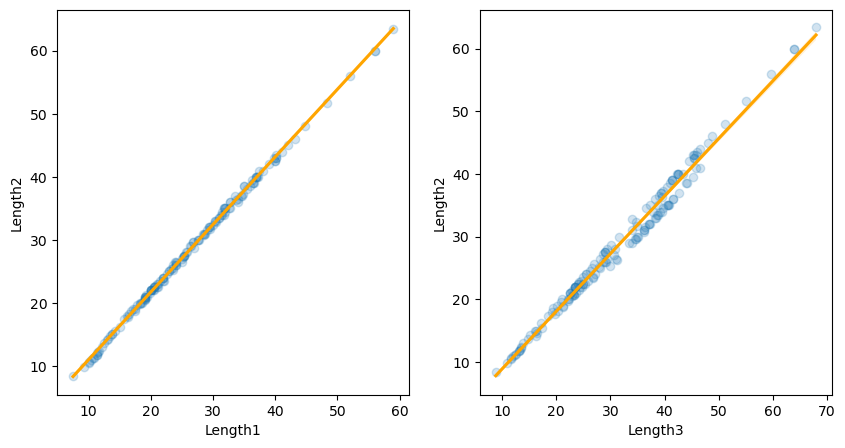

In [10]:
# plotting the data in a scatterplot with a fitted line plot ----------------------------------------------------------------- #
plt.clf()

n_X = len(model_df.columns)

fig = plt.figure(figsize=(5 * n_X ,5))

for i in range(1, n_X+1):
    ax = fig.add_subplot(1, n_X, i)
    sns.regplot(x=model_df[predicting_variables[i-1]], y=Y, line_kws={"color":"orange"}, scatter_kws={"alpha":0.2})

plt.show()

In [11]:
mean, std = stats.norm.fit(est.resid)

print("")
print("Mean of the residuals:")
print(mean)
print("")
print("Standard Deviation:")
print(std)


Mean of the residuals:
-1.5998383610195966e-14

Standard Deviation:
0.251766033080501


<Figure size 640x480 with 0 Axes>

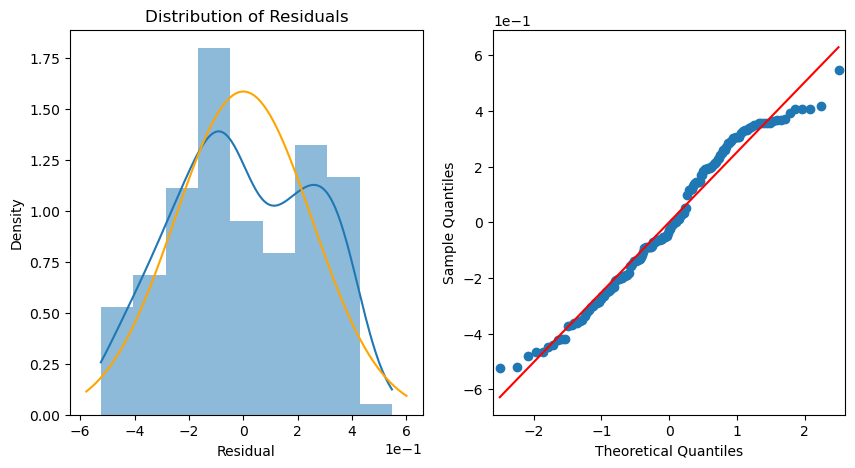

In [12]:
# Visualization of Error Normality ------------------------------------------------------------------------------------------- #
plt.clf()
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
# left visualization --------------------------------------------------------------------------------------------------------- #
sns.histplot(x = est.resid, ax=ax, stat = "density", linewidth = 0, kde = True)
ax.set(title="Distribution of Residuals", xlabel="Residual")

# normalcurve, for easy comparrison ------------------------------------------------------------------------------------------ #
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

#  right visualization ------------------------------------------------------------------------------------------------------- #
ax = fig.add_subplot(1,2,2)
sm.ProbPlot(est.resid).qqplot(line='s', ax=ax)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.show()

In [13]:
# Tests for Error Normality -------------------------------------------------------------------------------------------------- #

# Shapiro-Wilk-Test for Normality -------------------------------------------------------------------------------------------- #
sw_stat, sw_p = stats.shapiro(est.resid)
print("# Shapiro-Wilk-Test for Normality " + "-"*(122 - len("Shapiro-Wilk-Test for Normality")) + " #")
print("Test Statistic:")
print(sw_stat)
print("P-Value:")
print(sw_p)
print("")

print("Null Hypothesis:")
print("The data was drawn from a normal distribution.")
print("Alternative Hypothesis:")
print("The data was NOT drawn from a normal distribution.")
print("")

if sw_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Anderson-Darling-Test for Normality ---------------------------------------------------------------------------------------- #
def reject_null(stat, cv_arr, sl_arr, alpha):
    sl = 0
    index = 0
    sl_lst = np.ndarray.tolist(sl_arr)
    cv_lst = np.ndarray.tolist(cv_arr)
    for level in sl_lst:
        if level == alpha * 100:
            sl = level
            index = sl_lst.index(level)
    if cv_lst[index] < stat:
        return True
    else:
        return False

ad_stat, ad_cv, ad_sl = stats.anderson(est.resid)
print("# Anderson-Darling-Test for Normality " + "-"*(122 - len("Anderson-Darling-Test for Normality")) + " #")
print("Test Statistic:")
print(ad_stat)
print(f"Critical Value: {ad_cv}")
print(f"Significance Level: {ad_sl}")
print("")

print("Null Hypothesis:")
print("The sample is drawn from a population that follows a particular distribution. (Normal Distribution)")
print("Alternative Hypothesis:")
print("The sample is NOT drawn from a population that follows a particular distribution. (Normal Distribution)")
print("")

if reject_null(ad_stat, ad_cv, ad_sl, alpha):
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Kolmogorov-Smirnov-Test for Normality -------------------------------------------------------------------------------------- #
ks_stat, ks_p = stats.kstest(est.resid, stats.norm.cdf)
print("# Kolmogorov-Smirnov-Test for Normality " + "-"*(122 - len("Kolmogorov-Smirnov-Test for Normality")) + " #")
print("Test Statistic:")
print(ks_stat)
print("P-Value:")
print(ks_p)
print("")

print("Null Hypothesis:")
print("The two distributions are identical, F(x)=G(x) for all x. (default: two-sided)")
print("Alternative Hypothesis:")
print("They are NOT identical.")
print("")

if ks_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")


# Shapiro-Wilk-Test for Normality ------------------------------------------------------------------------------------------- #
Test Statistic:
0.9698365926742554
P-Value:
0.0014950827462598681

Null Hypothesis:
The data was drawn from a normal distribution.
Alternative Hypothesis:
The data was NOT drawn from a normal distribution.

Reject the null hypothesis, in favor of the alternative hypothesis.

# Anderson-Darling-Test for Normality --------------------------------------------------------------------------------------- #
Test Statistic:
1.3888003931473918
Critical Value: [0.562 0.641 0.768 0.896 1.066]
Significance Level: [15.  10.   5.   2.5  1. ]

Null Hypothesis:
The sample is drawn from a population that follows a particular distribution. (Normal Distribution)
Alternative Hypothesis:
The sample is NOT drawn from a population that follows a particular distribution. (Normal Distribution)

Reject the null hypothesis, in favor of the alternative hypothesis.

# Kolmogorov-Smirnov-T

In [14]:
# Tests for Constant Error Variance ------------------------------------------------------------------------------------------ #

# Levene Test for Equal Variances -------------------------------------------------------------------------------------------- #
sample_1 = est.resid[:79]
sample_2 = est.resid[80:]

l_stat, l_p = stats.levene(sample_1, sample_2)
print("# Levene Test for Equal Variances, significant deviations from normality" + "-"*(122 - len("Levene Test for Equal Variances, significant deviations from normality")) + " #")
print("Test Statistic:")
print(l_stat)
print("P-Value:")
print(l_p)
print("")

print("Null Hypothesis:")
print("All input samples are from populations with equal variances. (More robust with significantly non-normal populations)")
print("Alternative Hypothesis:")
print("NOT all input samples are from populations with equal variances.")
print("")

if l_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Bartlett'S Test for Equal Variances ---------------------------------------------------------------------------------------- #
b_stat, b_p = stats.bartlett(sample_1, sample_2)
print("# Bartlett'S Test for Equal Variances, NO significant deviations from normality" + "-"*(122 - len("Bartlett'S Test for Equal Variances, NO significant deviations from normality")) + " #")
print("Test Statistic:")
print(b_stat)
print("P-Value:")
print(b_p)
print("")

print("Null Hypothesis:")
print("All input samples are from populations with equal variances.")
print("Alternative Hypothesis:")
print("NOT all input samples are from populations with equal variances.")
print("")

if b_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Breusch-Pagan Test for Constant Error Variance ----------------------------------------------------------------------------- #
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(est.resid, est.model.exog)
print("# Breusch-Pagan Test for Constant Error Variance " + "-"*(122 - len("Breusch-Pagan Test for Constant Error Variance")) + " #")
print("Test Statistic (LM, F):")
print(f"{lm}, {fvalue}")
print("P-Value (LM, F):")
print(f"{lm_pvalue}, {f_pvalue}")
print("")

print("Null Hypothesis:")
print("The variance is constant.")
print("Alternative Hypothesis:")
print("The variance is NOT constant.")
print("")

if f_pvalue <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")


# Levene Test for Equal Variances, significant deviations from normality---------------------------------------------------- #
Test Statistic:
6.648177744798421
P-Value:
0.010850395012597958

Null Hypothesis:
All input samples are from populations with equal variances. (More robust with significantly non-normal populations)
Alternative Hypothesis:
NOT all input samples are from populations with equal variances.

Reject the null hypothesis, in favor of the alternative hypothesis.

# Bartlett'S Test for Equal Variances, NO significant deviations from normality--------------------------------------------- #
Test Statistic:
2.3195920602426066
P-Value:
0.12775352605952345

Null Hypothesis:
All input samples are from populations with equal variances.
Alternative Hypothesis:
NOT all input samples are from populations with equal variances.

Do not reject the null hypothesis.

# Breusch-Pagan Test for Constant Error Variance ----------------------------------------------------------------------